# Welcome to part 2 of our hands-on lab on RAG with watsonx.data and watsonx.ai leveraging Milvus vector database

This notebook focuses on the integration of watsonx.ai and watsonx.data platforms through Milvus. In this exercise, you will learn how to search data and generate results using the Large Language Models (LLMs) from watsonx.ai, applied to the documents ingested in the previous notebook within watsonx.data.

To achieve this, you will first need to vectorize the data and store it in the Milvus vector database. This will enable you to perform similarity searches on the ingested data before generating responses using watsonx.ai. Follow the steps provided to successfully complete the integration and explore the capabilities of these platforms.

The following steps will be performed:

1. Create a connection to IBM Cloud and the watsonx.data platform

2. Establish a connection to Milvus vector database and create a collection to store the embeddings

3. Embed/vectorize the data from the watsonx.data table and insert the embeddings into Milvus

4. Query Milvus and invoke LLM from watsonx.ai to generate responses on our questions

### Install the required libraries to run this notebook

In [ ]:
!pip install ipython-sql==0.4.1 sqlalchemy==1.4.46 pyhive[presto] pymilvus==2.3.7 sentence_transformers ibm-cloud-sdk-core ibm-watson-machine-learning pandas grpcio-tools torch==2.7.0 | tail -n 1

In [ ]:
!pip install PyPDF2

### Load credentials to connect to IBM Cloud and ibm-watson-machine-learning 


In order to connect to the IBM cloud, you would need three connection variables namely the `IBM cloud API_KEY`, `IBM cloud URL`, and the watsonx.ai `project ID`. 

Steps to fetch the connection variables- 

`api_key` -> 
1. click https://cloud.ibm.com/iam/apikeys  
2. click **Create**  
3. Provide the name of your choice  
4. click **Create** and copy-paste the key into a safe place.  
5. Paste the key in the cell below where mentioned.



`ibm_cloud_url` -> The IBM Cloud URL is the URL of the Watson Machine Learning instance associated with your project. The URL will be in the following format: https://`<region>`.ml.cloud.ibm.com. The region will be one of the following as shown in the image below. Check the region in the top bar of watsonx.ai page and copy-paste the URL accordingly in the cell below.
        
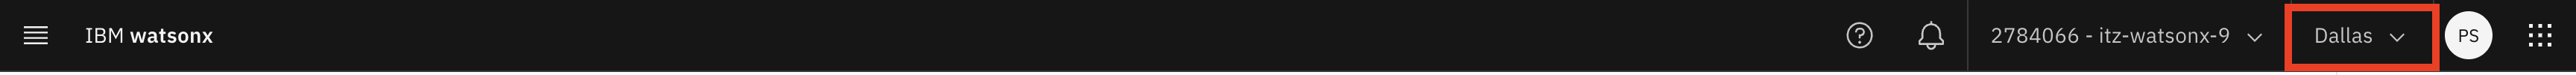    

* Dallas - https://us-south.ml.cloud.ibm.com
* London - https://eu-gb.ml.cloud.ibm.com
* Frankfurt - https://eu-de.ml.cloud.ibm.com
* Tokyo - https://jp-tok.ml.cloud.ibm.com


    
`project_id` -> This is the project-id of your watsonx.ai project.  
1. Check the URL of the page that you're currently in.   
2. Copy the value in the **projectid** section
3. Paste it in the cell below.  

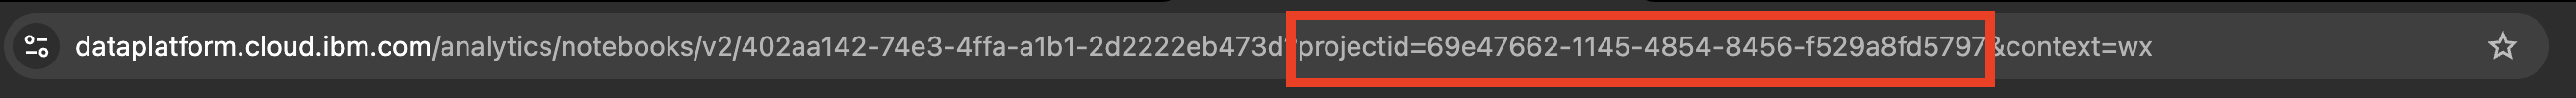

Once the values are filled in the cell below, your connection variables should look something like this:

* api_key =       'xxxxxxxxxxxxxxxxxxxx'
* ibm_cloud_url = 'https://us-south.ml.cloud.ibm.com'
* project_id =    '69e47662-1145-4854-8456-f529a8fd5797'

Note: your connection values will be different from the above example. 

In [ ]:
from ibm_cloud_sdk_core import IAMTokenManager
from ibm_watson_studio_lib import access_project_or_space

# Enter the Connection variables here:
api_key =       'APIKEY'
ibm_cloud_url = 'https://us-south.ml.cloud.ibm.com'
project_id =    'PROJECT_ID'
^

creds = {
    "url": ibm_cloud_url,
    "apikey": api_key 
}

access_token = IAMTokenManager(
    apikey = api_key,
    url = "https://iam.cloud.ibm.com/identity/token"
).get_token()

In [ ]:
#You will now be required to download the presto.crt file from the project into our notebook. For that we would use watson-studio-lib
from ibm_watson_studio_lib import access_project_or_space

wslib = access_project_or_space({
        'token': f'{access_token}',
        'project_id': f'{project_id}'
})



In [ ]:
wslib.list_connections()

In [ ]:
milvus_credentials = wslib.get_connection('watsonX-data-milvus-Milvus-Starter')

In [ ]:
milvus_credentials

In [ ]:
from pymilvus import(
    Milvus,
    IndexType,
    Status,
    connections,
    FieldSchema,
    DataType,
    Collection,
    CollectionSchema,
)


url = milvus_credentials['host']
port = milvus_credentials['port']
apikey = milvus_credentials['password']
apiuser = 'ibmlhapikey'


connections.connect(alias="default", 
                    host=url, 
                    port=port, 
                    user=apiuser, 
                    password=apikey, 
                    secure=True)

In [ ]:
# Create collection - define fields + schema

fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True), # Primary key
    FieldSchema(name="article_text", dtype=DataType.VARCHAR, max_length=2500,),
    FieldSchema(name="article_title", dtype=DataType.VARCHAR, max_length=200,),
    FieldSchema(name="vector", dtype=DataType.FLOAT_VECTOR, dim=384),
]

schema = CollectionSchema(fields, "watsonx collection schema")

collection = Collection("milvus", schema)

# Create index
index_params = {
        'metric_type':'L2',
        'index_type':"IVF_FLAT",
        'params':{"nlist":1250}
}

collection.create_index(field_name="vector", index_params=index_params)
## Status(code=0, message=) means success! 

In [ ]:
# You can run a check to see the collections in our milvus instance and see if our collection has been created 
from pymilvus import utility
utility.list_collections()

### Vectorize the data and load the embeddings to Milvus

AI models are capable of understanding only numeric values. Since our data is in the form of text, you would need to convert them to numerical representations called embeddings. This operation is performed by using embedding models which transform the texts into numerical values.

Here you will extract the data that was loaded into watsonx.data from the previous notebook, vectorize them using the `sentence-transformers/all-MiniLM-L6-v2` sentence transformer model and load it into the Milvus vector database. 
Learn more about Hugging Face sentence transformers here: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

You must assemble the article text, article titles, and vector embeddings into a `data` object. This object will be used to load the data into Milvus.

In [ ]:
pdf_path = wslib.download_file('2024 Academy Awards Summary.PDF')
pdf_path

In [ ]:
import PyPDF2

actual_pdf_path = "/home/wsuser/work/2024 Academy Awards Summary.PDF"

all_text = ""
with open(actual_pdf_path, "rb") as f:
    reader = PyPDF2.PdfReader(f)
    for page in reader.pages:
        text = page.extract_text()
        if text:
            all_text += text + "\n"

print(all_text[:1000])  


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

CHUNK_SIZE = 500
CHUNK_OVERLAP = 50

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP
)

chunks = text_splitter.split_text(all_text)

print(f"✅ Total {len(chunks)} chunks")
print("🔹 Example chunks:")
print(chunks[0])


In [ ]:
from sentence_transformers import SentenceTransformer
from pymilvus import Collection


model = SentenceTransformer("all-MiniLM-L6-v2")  # 384 
embeddings = model.encode(chunks)
basic_collection = Collection("milvus") 
basic_collection.load()


titles = [""] * len(chunks)


data = [
    chunks,     # article_text
    titles,     # article_title
    embeddings  # vector
]

out = basic_collection.insert(data)
basic_collection.flush()  


In [ ]:
## check to ensure entities have been loaded into the collection
## The output should be 210 in this exercise
basic_collection = Collection("milvus") 
basic_collection.num_entities 

### Query Milvus & Prompt LLM

After gathering the data from document and then vectorizing it and inserting into Milvus, you are now ready to perform queries against the vector database. You will use the same `all-MiniLM-L6-v2` embedding model to generate the query vector and then use Milvus to find the most similar vectors in the database.

Load Milvus Collection and create a function to generate results from the vector database as per our question 

In [ ]:
# Load collection
basic_collection = Collection("milvus")      
basic_collection.load()

# Query function
def query_milvus(query, num_results=5):
    
    # Vectorize query
    model = SentenceTransformer("all-MiniLM-L6-v2") # 384 dim
    query_embeddings = model.encode([query])

    # Search
    search_params = {
        "metric_type": "L2", 
        "params": {"nprobe": 5}
    }
    results = basic_collection.search(
        data=query_embeddings, 
        anns_field="vector", 
        param=search_params,
        limit=num_results,
        expr=None, 
        output_fields=['article_text'],
    )
    return results

Enter the question in the question_text string below

In [ ]:
#Prompt questions for Query results
question_text = "Who hosted the 2024 Academy Awards?"
#question_text = " Explain watsonx.data in 1000 words? "

Invoke the query_milvus function to retrieve similar vectors from Milvus

In [ ]:
# Query Milvus 

num_results = 1
results = query_milvus(question_text, num_results)

relevant_chunks = []
for i in range(num_results):    
    text = results[0][i].entity.get('article_text')
    relevant_chunks.append(text)
    
print(relevant_chunks[0])
print(relevant_chunks[1])
print(relevant_chunks[2])


Create a prompt for the LLM by joining the instructions, question and the retrieved results from Milvus

In [ ]:
def make_prompt(context, question_text):
    return (
        f"Answer this question using ONLY the context below. "
        f"Do not repeat the question. Do not explain. Just give the answer. "
        f"If the answer is not in the context, return: unanswerable\n\n"
        f"Context:\n{context}\n\n"
        f"Question: {question_text}\n"
        f"Answer:"
    )



# Build prompt w/ Milvus results
# Embed retrieved passages(context) and user questions into prompt text
context = "\n\n".join(relevant_chunks)
prompt = make_prompt(context, question_text)

### Invoke the Large language model from watsonx.ai, initiate the decoding parameters and generate results as per the prompt

Here you will be using the IBM's flagship `meta-llama/llama-4-maverick-17b-128e-instruct-fp8` generative AI model

In [ ]:
from ibm_watson_machine_learning.foundation_models import Model
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams

# Model Parameters
params = {
        GenParams.DECODING_METHOD: "greedy",
        GenParams.MIN_NEW_TOKENS: 1,
        GenParams.MAX_NEW_TOKENS: 200,
        GenParams.TEMPERATURE: 0.0,
}
model = Model(
        model_id='meta-llama/llama-4-maverick-17b-128e-instruct-fp8', 
        params=params, credentials=creds, 
        project_id=project_id
)

# Prompt LLM
response = model.generate_text(prompt)
print(f"Question: {question_text}{response}")

#### You can now save this notebook. Click `File` in the menu bar and then `save`.

## Congratulations!! You have successfully created a RAG Q&A use case and reached the end of the notebook. Switch over to the lab guide for follow-up details and next steps.